# The Stability of the Planetary Orbits

## Call the C library ODE solver

In [1]:
import ctypes
from ctypes import *
from numpy.ctypeslib import ndpointer
import numpy as np
import matplotlib.pyplot as plt
import numba
import csv
import random

# ODE solver
import odesolver
from odesolver import *

# neural network model
import model
from model import *

# equations of motion, transformation of coordinates
import physics
from physics import *

In [33]:
# set formatting of the plots
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import rc

#choose Computer Modern Roman fonts by default
mpl.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.handlelength'] = 2
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['agg.path.chunksize'] = 10000

In [1]:
#!gcc -shared -O2 ode.c -o libode.so

## The right-hand side of the equation of motion: $\frac{d\vec z}{dt} = \vec f(t,\vec z)$ is in physics.py

### Mercury, Venus, Earth, Mars, Jupiter, Saturn, and the Sun

## Run the simulation

### Initial conditions:
##### Mercury  $a_m=0.39 AU, \ e_m=0.206, \ \theta_E = -3\pi/4, \ \theta_m=\theta_E$
##### Venus $M_V = 0.000002447M_S, \ a_V = 0.72 AU, \ T_V = 0.615 years,\ \theta_V = 0$
##### Earth $M_E = M_S/333030, \ a_E = 1 AU, \ T_E = 1 years,\ \theta_E = 0$
##### Mars $M_M = 0.0000003213M_S, \ a_M = 1.52 AU, \ T_M = 1.88 years,\ \theta_M = 0$
##### Jupiter $M_J = M_S/1048, \ a_J = 5.20 AU, \ T_J = 11.86 years,\ \theta_J = 0$
##### Saturn $M_S = 0.0002857M_S, \ a_S = 9.58 AU, \ T_J = 29.46 years,\ \theta_J = 0$

In [4]:
# compute initial conditions of Mercury in cartesian coordinates
am = 0.39
em = 0.206
thetaEm = -0.75 * np.pi
thetam = thetaEm

init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))
planets = np.array([0.000002447, 0.72, 0.615,
                    1./333030., 1., 1.,
                    0.0000003213, 1.52, 1.88,
                    1./1048., 5.20, 11.86,
                    0.0002857, 9.58, 29.46])

In [6]:
# run the simulation
dt = 0.001
time_f = 10000.
nsteps = int(time_f/dt)
t,zm = solve_ode(funcpl,[0.,time_f], nsteps, init_cart, args=planets, method="Yoshida4")
xm,Vmx,ym,Vmy = zm.T

# compute the parameters of the ellipse
a,e,theta,thetaE = xy_to_ellipse(xm,Vmx,ym,Vmy)

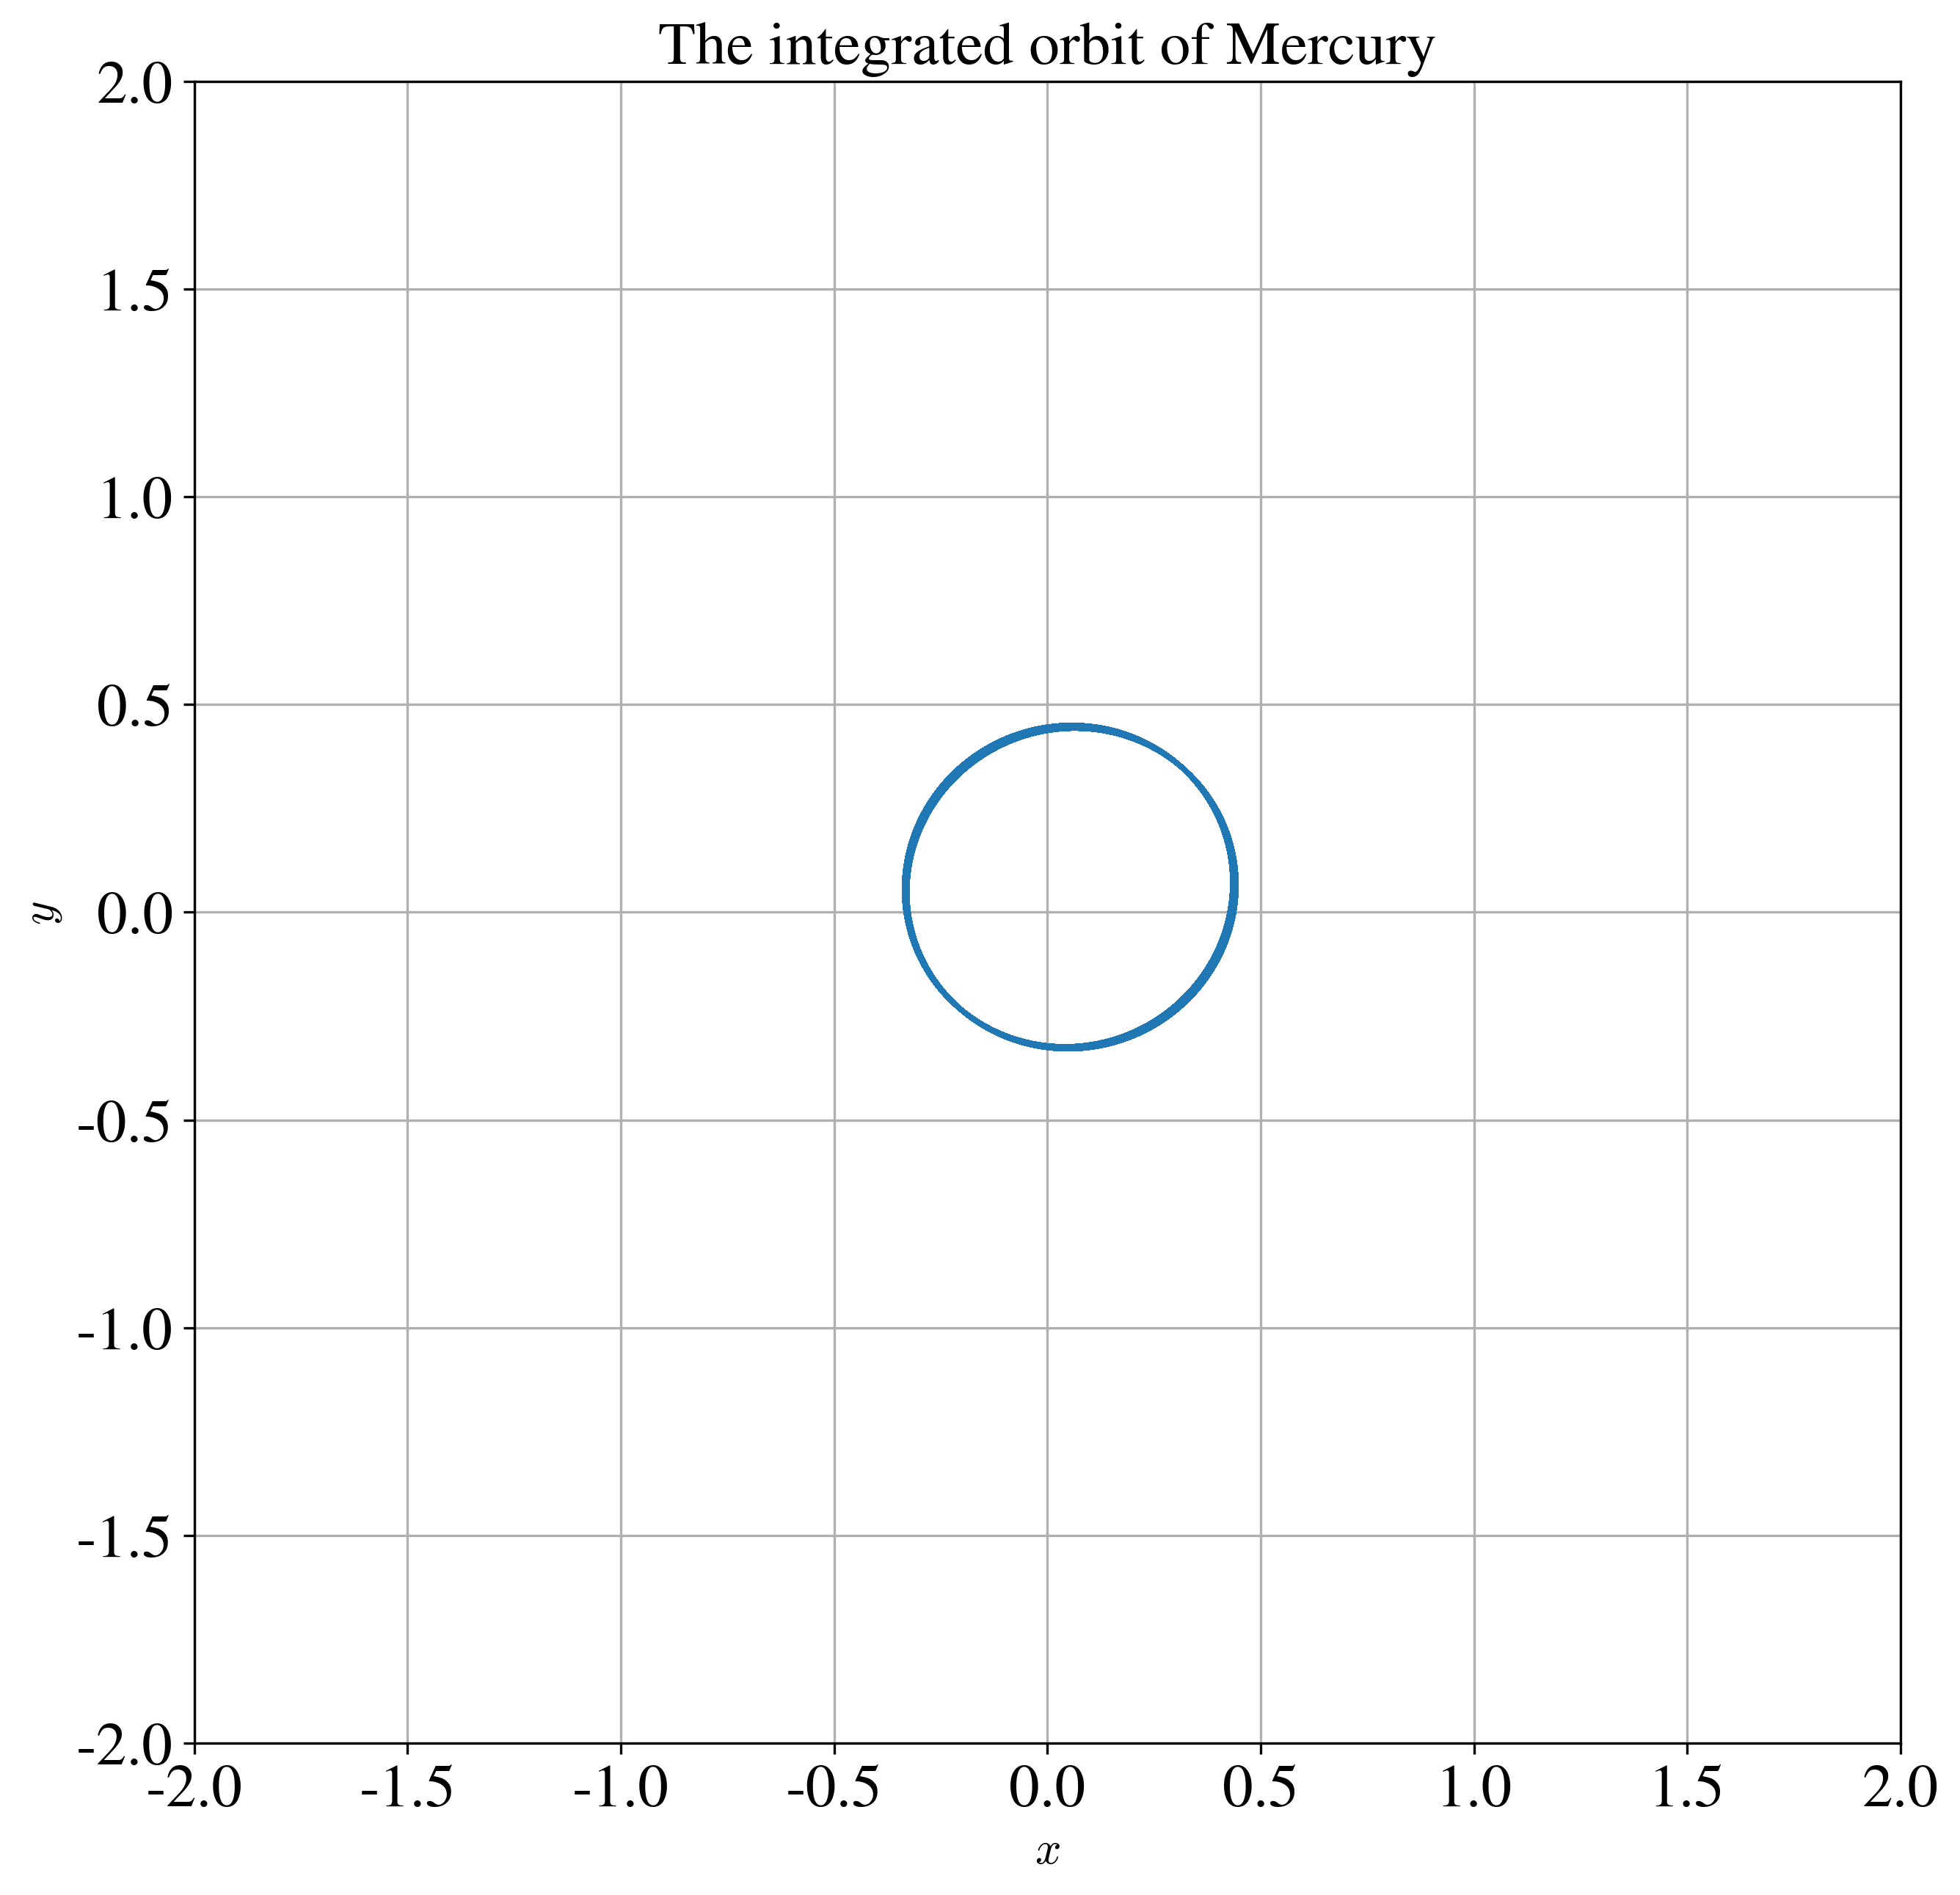

In [36]:
plt.figure(figsize=(10,10))
plt.title(r"The integrated orbit of Mercury")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")

plt.plot(xm,ym)
#plt.legend()
plt.grid()

axes = plt.gca()
axes.set_xlim([-2,2])
axes.set_ylim([-2,2])

plt.savefig("mercury_planets.png",bbox_inches="tight")

## Labeling the data
##### Decide whether Mercury is still on the orbit

In [38]:
# if major semiaxis exceeds 10 AU, Mercury is ejected from the system 
# if stability is 1, Mercury is not ejected; otherwise, we say that it is ejected

stability = int(np.count_nonzero((a>10))==0)
print(stability)

1


## Running simulations with pertubations
##### Modify the initial conditions of Mercury

In [18]:
# training set

thetaEm = -0.75 * np.pi
thetam = thetaEm
init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))
planets = np.array([0.000002447, 0.72, 0.615,
                    1./333030., 1., 1.,
                    0.0000003213, 1.52, 1.88,
                    1./1048., 5.20, 11.86,
                    0.0002857, 9.58, 29.46])

dt = 0.001
time_f = 10000.
nsteps = int(time_f/dt)


with open('train.csv', mode='a', newline='') as file:
    for iteration in range(0,500):
        # add pertubations to the orbit of Mercury
        am = random.uniform(0.1,5.0)
        em = random.gauss(0.206, 0.01)
        init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))

        # run the simulation
        t,zm = solve_ode(funcpl,[0.,time_f], nsteps, init_cart, args=planets, method="Yoshida4")
        xm,Vmx,ym,Vmy = zm.T

        # compute the parameters of the ellipse
        a,e,theta,thetaE = xy_to_ellipse(xm,Vmx,ym,Vmy)

        # 1 if stable, 0 if unstable
        stability = int(np.count_nonzero((a>10))==0)
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        data = [am, em, stability]
        writer.writerow(data)

In [33]:
# test set

thetaEm = -0.75 * np.pi
thetam = thetaEm
init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))
planets = np.array([0.000002447, 0.72, 0.615,
                    1./333030., 1., 1.,
                    0.0000003213, 1.52, 1.88,
                    1./1048., 5.20, 11.86,
                    0.0002857, 9.58, 29.46])

dt = 0.001
time_f = 10000.
nsteps = int(time_f/dt)


with open('test.csv', mode='a', newline='') as file:
    for iteration in range(0,250):
        # add pertubations to the orbit of Mercury
        am = random.uniform(0.1,5.0)
        em = random.gauss(0.206, 0.01)
        init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))

        # run the simulation
        t,zm = solve_ode(funcpl,[0.,time_f], nsteps, init_cart, args=planets, method="Yoshida4")
        xm,Vmx,ym,Vmy = zm.T

        # compute the parameters of the ellipse
        a,e,theta,thetaE = xy_to_ellipse(xm,Vmx,ym,Vmy)

        # 1 if stable, 0 if unstable
        stability = int(np.count_nonzero((a>10))==0)
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        data = [am, em, stability]
        writer.writerow(data)

## Predicting the stability of the system

In [8]:
# read data
a_train,e_train,stability_train = np.loadtxt("train.csv",delimiter=',',unpack=True)
m_train = a_train.shape[0]
print(m_train)

# create an array of X and Y
X_train = np.zeros((2,m_train))
X_train[0,:] = a_train
X_train[1,:] = e_train

Y_train = stability_train

print(X_train.shape)
print(Y_train.shape)

# reshape X_train and Y_train to avoid having rank 1 array 
X_train = X_train.reshape(2,m_train)
Y_train = Y_train.reshape(1,m_train)

print(X_train.shape)
print(Y_train.shape)

500
(2, 500)
(500,)
(2, 500)
(1, 500)


In [26]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X_train, Y_train, n_h=4, num_iterations=10000, print_cost=True)

# Print accuracy
predictions_train = predict(parameters, X_train)

Cost after iteration 0: 0.693035
Cost after iteration 1000: 0.288190
Cost after iteration 2000: 0.272064
Cost after iteration 3000: 0.253229
Cost after iteration 4000: 0.249525
Cost after iteration 5000: 0.247474
Cost after iteration 6000: 0.246544
Cost after iteration 7000: 0.246056
Cost after iteration 8000: 0.245648
Cost after iteration 9000: 0.245290


In [27]:
accuracy_train = (np.count_nonzero(predictions_train[0] == Y_train[0]))/m_train * 100.
print("Accuracy for the training set: %0.1f %%" %accuracy_train)

Accuracy for the training set: 90.8 %


In [28]:
# read data
a_test,e_test,stability_test = np.loadtxt("test.csv",delimiter=',',unpack=True)
m_test = a_test.shape[0]
print(m_test)
# create an array of X and Y
X_test = np.zeros((2,m_test))
X_test[0,:] = a_test
X_test[1,:] = e_test

Y_test = stability_test

print(X_test.shape)
print(Y_test.shape)

# reshape X_test and Y_test
X_test = X_test.reshape(2,m_test)
Y_test = Y_test.reshape(1,m_test)

print(X_test.shape)
print(Y_test.shape)

250
(2, 250)
(250,)
(2, 250)
(1, 250)


In [29]:
# Compute and print accuracy
predictions = predict(parameters, X_test)
accuracy_test = (np.count_nonzero(predictions[0] == Y_test[0]))/m_test * 100.
print("Accuracy for the training set: %0.1f %%" %accuracy_test)

Accuracy for the training set: 91.6 %
